In [1]:
from IPython.display import display
from sympy import (Symbol, plot_parametric, pi, I, Max, And, sqrt,
                   tan, cos, lambdify, Poly, Rational as R)
from utils import (reim, splot_multiple, f2zpk, move_sympyplot_to_axes,
                   random_bright_rgb_color as rcolor, curves_iter, f2nd,
                   change_figure_size)
from more_itertools import grouper
from routh import routh_row
from matplotlib import pyplot
from functools import partial
pmplot = partial(splot_multiple, plotf=plot_parametric)

# Análisis de estabilidad para un sistema de lazo cerrado

Se procede a analizar la estabilidad del sistema $H$ retroalimentado negativamente mediante $G$. Se listan los parámetros del sistema:

$$H(s)=\frac{s-1}{s^2+13s+30}=\frac{s-1}{(s+3)(s+10)}$$
$$G(s)=\frac{k}{s}\quad\forall k\in\Re$$

La ecuación que define al sistema de lazo cerrado resulta ser la siguiente:

$$R(s)=\frac{N(s)}{D(s)}=\frac{Y(s)}{X(s)}=\frac{H(s)}{G(s)\cdot H(s)+1}$$
donde $Y(s)$ representa la respuesta del sistema para cualquier entrada $X(s)$. Para determinar la estabilidad del sistema entonces será necesario analizar el denominador de $R(s)$ y los polos de $H(s)$.

In [2]:
s = Symbol("s")
w = Symbol("omega", real=True)
t = Symbol("t", real=True)

In [3]:
k = Symbol("k", real=True)
g_h_s = k/s * (s-1)/(s**2 + 13*s + 30)

## Utilizando el criterio de estabilidad de Nyquist

El criterio de Nyquist nos permite analizar al sistema cómo si fuese de lazo abierto ($G(s)\cdot H(s)$), dado que los ceros del denominador de $R(s)$ son los polos de la función de transferencia de lazo cerrado, analizar los ceros de $G(s)\cdot H(s)+1$ será suficiente para determinar la estabilidad de $R(s)$, suponiendo la estabilidad de $H(s)$.

Mediante el Principio del Argumento de Cauchy, se deduce que para una función de mapeo $f(z)$, si existe un contorno $C$ cerrado en $z$ para el cual $f(z)$ resulte analítica sobre el mismo, la cantidad de veces que el contorno mapeado $f(z)\rvert_{C}$ rodee el origen es igual a la diferencia entre la cantidad de ceros y polos rodeados por $C$ en el plano $z$. Ésta relación puede expresarse cómo $N=Z-P$. De ésta forma, si construimos un contorno $C$ cerrado en $s$ que rodee a todo el semiplano $\Re(s)\ge 0$, la estabilidad del sistema dependerá de que el contorno mapeado en $D(s)$ rodee al origen en el sentido opuesto tantas veces cómo polos existan dentro de $C$ en el plano $s$.

Volviendo al caso bajo análisis, debido a que la función de transferencia $G(s)$ presenta un polo simple centrado en el origen se suma una pequeña protuberancia que deflecta el contorno hacia la derecha para evadirlo. Dado que los polos de $G(s)$ y $H(s)$ todos tienen parte real negativa a excepción del polo en el origen, el contorno planteado solamente debería rodear ceros en el semiplano derecho de existir alguno. Por lo que $N = Z$.

Así procedemos a realizar el mapeo de $D(s) - 1$

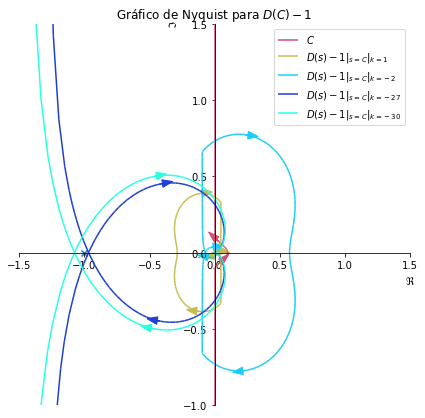

In [4]:
path = (Max(cos(2*t), 0)+I*tan(t)) / 10
ks = (1, -2, -27, -30)
curves = (
    ((*reim(path), (t, -pi/2, pi/2)), dict(label="$C$")),
    *(((*reim(g_h_s.subs(s, path).subs(k, value)), (t, -pi/2, pi/2)),
        {"label": r"$D(s)-1|_{s=C}|_{k="+ str(value) +r"}$"}) for
     value in ks)
)
curves = tuple(((curve, {**props, "line_color": rcolor()}) \
    for curve, props in curves))
with change_figure_size(7, 7, pyplot):
    nyquist_plot = pmplot(*curves,
        xlim=(-1.5, 1.5), ylim=(-1, 1.5), show=False, legend=True,
        title="Gráfico de Nyquist para $D(C)-1$",
        ylabel=r"$\Im$", xlabel=r"$\Re$"
    )
    fig, ax = pyplot.subplots()
for curve, props in curves_iter(curves):
    x, y = curve[:-1]
    dx, dy = x.diff(t), y.diff(t)
    #x, y, dx, dy = (lambdify(t, f) for f in (x, y, dx, dy))
    ats = (pi/2 * 0.4, -pi/2 * 0.4, pi/2 * 0.98, -pi/2 * 0.98)
    for at in ats:
        xn, yn, dxn, dyn = (float(expr.subs(t, at)) for expr in (x, y, dx, dy))
        dxn, dyn = (dn / (10*(dxn**2 + dyn**2)**(1/2)) for dn in (dxn, dyn))
        ax.arrow(xn, yn, dxn, dyn, head_length=.08, length_includes_head=True,
            color=props["line_color"], head_starts_at_zero=False,
            head_width=.05)
ax.scatter(-1, 0, marker="x")
move_sympyplot_to_axes(nyquist_plot, ax)
pyplot.show()

En el gráfico se observa que para valores de $k$ cercanos a cero la curva mapeada presenta un quiebre seguido por una forma en gran parte circular para luego cerrar sobre si misma en otro quiebre, la sección circular se debe a que el desvío al polo sobre el origen se realiza de manera que el radio tenga un valor finito, si bien muy pequeño, simplemente para demostrar sobre qué lado del plano se cierra la curva que de no ser por el desvío tomaría valores hacia $\tilde\infty$. El mismo comportamiento se espera para valores de $k$ mucho mayores que cero, solamente que para éstos la curva se encuentra fuera de la sección del plano graficado. Por ésta razón, para $k>0$ el sistema resulta ser inestable, dado que el contorno estaría comprendiendo todo el semiplano izquierdo, incluido el origen en $-1$. Entonces el sistema presenta estabilidad de primer orden (una única rotación sobre $-1$) para valores de $k$ mayores a cero y será marginalmente estable para $k=0$

Otro caso de inestabilidad se da para cuando el punto dónde la curva mapeada se intersecta sobre si misma en el eje $\Re$ es menor que $-1$, para un valor suficientemente negativo de $k$ por debajo de un límite que nombraremos $k_{min}$.

Se puede observar además en la función de transferencia de lazo cerrado que el margen de amplitud es proporcional en un desplazamiento a la constante $k$, debido a que $k$ es la ganancia del sistema de lazo abierto, de forma qué $m_a = 1 - k/k_{min}$, dónde $k_{min}$ es el valor de $k$ mínimo, para cual el sistema se vuelve marginalmente estable. El margen de fase resultará en una función $k$, la cual disminuirá monótonamente desde $90°$ para $k\to -0$ hasta $0°$ para $k\to k_{min}$.

Una vez $k<k_{min}$, la curva mapeada pasará a rodear el punto $-1$ dos veces, por lo que tendremos dos polos complejos conjugados con componentes reales positivas en la función de transferencia de lazo cerrado, el sistema así será inestable de segundo orden. En cuanto al valor numérico de $k_{min}$, resultará más conveniente utilizar el criterio de Routh para determinarlo.

## Utilizando el criterio de Routh
El denominador de la función de transferencia para el sistema de lazo cerrado resulta del producto entre $G(s)$ y $H(s)$ mas uno. El criterio de estabilidad de Routh nos permite analizar la estabilidad del sistema de lazo cerrado utilizando los coeficientes del polinomio que conforma el denominador de la función de transferencia, ya que los polos son los que determinan la estabilidad del sistema.

$$D(s)=1+\frac{k}{s}\frac{s-1}{s^2 + 13s + 30}$$

el numerador de $D(s)$ puede ser expresado en función de los coeficientes del polinomio de $s$

$$a_0s^3+a_1s^2+a_2s+a_3 \implies a_0=1\land a_1=13\land a_2=30+k\land a_3=-k$$

Para el criterio de Routh se organizan los coeficientes $a$ en forma matricial

$$
\begin{bmatrix}
    a_0 & a_2 \\
    a_1 & a_3
\end{bmatrix} = 
\begin{bmatrix}
    1 & 30+k \\
    13 & -k
\end{bmatrix}
$$

Se aumenta la matriz en una fila con los siguientes valores

$$
\begin{bmatrix}
    a_0 & a_2 \\
    a_1 & a_3 \\
    \frac{a_2\cdot a_1-a_0\cdot a_3}{a_1} &
\end{bmatrix} = 
\begin{bmatrix}
    1 & 30+k \\
    13 & -k \\
    30+14/13\cdot k &
\end{bmatrix}
$$

Nuevamente se aumenta la matriz en una fila, satisfaciendo la dimensión $n+1$

$$
\begin{bmatrix}
    a_0 & a_2 \\
    a_1 & a_3 \\
    \frac{a_2\cdot a_1-a_0\cdot a_3}{a_1} & \\
    a3 &
\end{bmatrix} = 
\begin{bmatrix}
    1 & 30+k \\
    13 & -k \\
    30+14/13\cdot k & \\
    -k &
\end{bmatrix}
$$

Dado que algunos de los elementos de la primera columna pueden cambiar de signo en función a $k$, se debe resolver algún dominio de $k$ que satisfaga la condición $30+14/13\cdot k>0\land -k>0$ para determinar la condición de estabilidad del sistema.

$$30+14/13\cdot k>0 \implies 30>-14/13\cdot k\implies -30\cdot 13/14<k$$

$$\therefore\quad -30\cdot 13/14<k<0$$

Así el sistema será estable para el intervalo $-30\cdot 13/14<k<0$ y marginalmente estable para $k=-30\cdot 13/14$ y para $k=0$, por lo que $k_{min}=-30\cdot 13/14$. En el caso particular de $k=0$, puede interpretarse cómo ganancia de retroalimentación nula, por lo que el lazo cerrado no tiene influencia sobre $H(s)$.

In [5]:
# Separando los coeficientes pares e impares del polinomio
# para formar las primeras dos filas de la matriz
i0, i1 = zip(*grouper(
    Poly(f2nd(1 + g_h_s)[0], s).coeffs(), 2, 0))
# Obteniendo las filas subsequentes
i2 = tuple(routh_row(i0, i1))
i3 = tuple(routh_row(i1, i2))
assert len(i2) == 1 and len(i3) == 1
#display(i0, i1, i2, i3)
# Para cada fila, el primer elemento debe ser mayor a cero
And(*(row[0] > 0 for row in (i0, i1, i2, i3))).simplify()

(k > -195/7) & (k < 0)

In [6]:
#display(*(x.subs(k, 0.01).n() for x in f2zpk(1 + g_h_s, s)[0]))